# **[Adversarial Disturbances for Controller Verification](http://proceedings.mlr.press/v144/ghai21a/ghai21a.pdf)**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/nsc-tutorial/blob/main/controller-verification.ipynb)

## Housekeeping
Imports [jax](https://github.com/google/jax), numpy, scipy, plotting utils...

In [43]:
#@title

import jax
import itertools
import numpy as onp
import jax.numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from jax.numpy.linalg import inv, pinv
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad, hessian
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain

def liveplot(costss, xss, wss, cmax=30, cumcmax=15, wmax=2, xmax=20, logcmax=100, logcumcmax=1000):
    cummean = lambda x: np.cumsum(np.array(x))/np.arange(1, len(x)+1)
    cumcostss = valmap(cummean, costss)
    disturbances = valmap(lambda x: list(map(lambda w: w[0], x)), wss)

    #plt.style.use('seaborn')
    colors = {
        "Zero Control": "gray",
        "LQR / H2": "green",
        "Finite-horizon LQR / H2": "teal",
        "Optimal LQG for GRW": "aqua",
        "Robust / Hinf Control": "orange",
        "GPC": "red",
        "LQR PI Control": "purple" # Added color for LQR PI Control
    }

    fig, ax = plt.subplots(3, 2, figsize=(21, 12))

    costssline = {}
    for Cstr, costs in costss.items():
        costssline[Cstr], = ax[0, 0].plot([], label=Cstr, color=colors[Cstr])
    ax[0, 0].set_xlabel("Time")
    ax[0, 0].set_ylabel("Instantaneous Cost")
    ax[0, 0].set_ylim([-1, cmax])
    ax[0, 0].set_xlim([0, 100])
    ax[0, 0].legend()

    cumcostssline = {}
    for Cstr, costs in cumcostss.items():
        cumcostssline[Cstr], = ax[0, 1].plot([], label=Cstr, color=colors[Cstr])
    ax[0, 1].set_xlabel("Time")
    ax[0, 1].set_ylabel("Average Cost")
    ax[0, 1].set_ylim([-1, cumcmax])
    ax[0, 1].set_xlim([0, 100])
    ax[0, 1].legend()

    perturblines = {}
    for Cstr, W in disturbances.items():
        perturblines[Cstr], = ax[1, 0].plot([], label=Cstr, color=colors[Cstr])
    ax[1, 0].set_xlabel("Time")
    ax[1, 0].set_ylabel("Generated Disturbances")
    ax[1, 0].set_ylim([-wmax, wmax])
    ax[1, 0].set_xlim([0, 100])
    ax[1, 0].legend()

    pointssline, trailssline = {}, {}
    for Cstr, C in xss.items():
        pointssline[Cstr], = ax[1,1].plot([], [], label=Cstr, color=colors[Cstr], ms=20, marker='s')
        trailssline[Cstr], = ax[1,1].plot([], [], label=Cstr, color=colors[Cstr], lw=2)
    ax[1, 1].set_xlabel("Position")
    ax[1, 1].set_ylabel("")
    ax[1, 1].set_ylim([-1, 6])
    ax[1, 1].set_xlim([-xmax, xmax])
    ax[1, 1].legend()

    logcostssline = {}
    for Cstr, costs in costss.items():
        logcostssline[Cstr], = ax[2, 0].plot([1], label=Cstr, color=colors[Cstr])
    ax[2, 0].set_xlabel("Time")
    ax[2, 0].set_ylabel("Instantaneous Cost (Log Scale)")
    ax[2, 0].set_xlim([0, 100])
    ax[2, 0].set_ylim([0.1, logcmax])
    ax[2, 0].set_yscale('log')
    ax[2, 0].legend()

    logcumcostssline = {}
    for Cstr, costs in cumcostss.items():
        logcumcostssline[Cstr], = ax[2, 1].plot([1], label=Cstr, color=colors[Cstr])
    ax[2, 1].set_xlabel("Time")
    ax[2, 1].set_ylabel("Average Cost (Log Scale)")
    ax[2, 1].set_xlim([0, 100])
    ax[2, 1].set_ylim([0.1, logcumcmax])
    ax[2, 1].set_yscale('log')
    ax[2, 1].legend()

    def livedraw(t):
        for Cstr, costsline in costssline.items():
            costsline.set_data(np.arange(t), costss[Cstr][:t])
        for Cstr, cumcostsline in cumcostssline.items():
            cumcostsline.set_data(np.arange(t), cumcostss[Cstr][:t])
        for i, (Cstr, pointsline) in enumerate(pointssline.items()):
            pointsline.set_data([xss[Cstr][t][0]], [i])
        for Cstr, perturbline in perturblines.items():
            perturbline.set_data(np.arange(t), disturbances[Cstr][:t])
        for i, (Cstr, trailsline) in enumerate(trailssline.items()):
            trailsline.set_data(list(map(lambda x: x[0], xss[Cstr][max(t-10, 0):t])), [i])
        for Cstr, logcostsline in logcostssline.items():
            logcostsline.set_data(np.arange(t), costss[Cstr][:t])
        for Cstr, logcumcostsline in logcumcostssline.items():
            logcumcostsline.set_data(np.arange(t), cumcostss[Cstr][:t])
        return chain(costssline.values(), cumcostssline.values(), perturblines.values(), pointssline.values(), trailssline.values(), logcostssline.values(), logcumcostssline.values())

    print("🧛 reanimating :) meanwhile...")
    livedraw(99)
    plt.show()

    from matplotlib import animation
    anim = animation.FuncAnimation(fig, livedraw, frames=100, interval=50, blit=True)
    from IPython.display import HTML
    display.clear_output(wait=True)
    return HTML(anim.to_html5_video())

## A simple dynamical system
Defines a discrete-time [double-integrator](https://en.wikipedia.org/wiki/Double_integrator) -- a simple linear dynamical system that mirrors 1d kinematics -- along with a quadratic cost.

Below $\mathbf{x}_t$ is the state, $\mathbf{u}_t$ is the control input (or action), $\mathbf{w}_t$ is the disturbance.

$$ \mathbf{x}_{t+1} = A\mathbf{x}_t + B\mathbf{u}_t + \mathbf{w}_t, \qquad c(\mathbf{x},\mathbf{u}) = \mathbf{x}^\top Q \mathbf{x} + \mathbf{u}^\top R \mathbf{u}$$

$$ A = \begin{bmatrix}
1 & 1\\
0 & 1
\end{bmatrix},\quad B = \begin{bmatrix}
0\\
1
\end{bmatrix}, \quad Q = \begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}, \quad R = \begin{bmatrix}
1
\end{bmatrix}$$

In the task of controller verification, the **verifier** selects $\mathbf{w}_t$ adaptively as a function of past state-action pairs $(\mathbf{x}_s,\mathbf{u}_s:s\leq t)$.

In [44]:
dx, du, T = 2, 1, 100
A, B = np.array([[1.0, 1.0], [0.0, 1.0]]), np.array([[0.0], [1.0]])
Q, R = np.eye(dx), np.eye(du)

dyn = lambda x, u, w, t: A @ x + B @ u + w
cost = lambda x, u, t: x.T @ A @ x + u.T @ R @ u

# A basic control loop.
# (x, z) is the environ-controller state.
# w is disturbance and z_w disturbance generator state
def eval(control, disturbance):
    x, z, z_w = np.zeros(dx), None, None
    for t in range(T):
        u, z = control(x, z, t)
        w, z_w = disturbance(x, u, z_w, t)
        c = cost(x, u, t)
        yield (x, u, w, c)
        x = dyn(x, u, w, t)

## Control Algorithms
The segment below puts forth a few basic control strategies, whose performance characteristics we would like to verify.

+ **Zero Control**: Executes $\mathbf{u}=\mathbf{0}$.
+ **LQR / H2**: A discrete-time [linear-quadratic regulator](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator).
+ **Finite-horizon LQR / H2**: A finite-horizon variant of the above.
+ **Robust / $H_\infty$ Control**: A worst-case [robust](https://en.wikipedia.org/wiki/H-infinity_methods_in_control_theory) controller.
+ **GPC**: [Gradient-perturbation](https://arxiv.org/abs/1902.08721) controller.

In [45]:
#@title

def zero():
    return lambda x, z, t: (np.zeros(du), z)


def h2(A=A, B=B, Q=Q, R=R):
    P = dare(A, B, Q, R)
    K = - inv(R + B.T @ P @ B) @ (B.T @ P @ A)
    return lambda x, z, t: (K @ x, z)


def h2nonstat(A=A, B=B, Q=Q, R=R, T=T):
    dx, du = B.shape
    P, K = [np.zeros((dx, dx)) for _ in range(T + 1)], [np.zeros((du, dx)) for _ in range(T)]
    P[T] = Q
    for t in range(T - 1, -1, -1):
        P[t] = Q + A.T @ P[t + 1] @ A - (A.T @ P[t + 1] @ B) @ inv(R + B.T @ P[t + 1] @ B) @ (B.T @ P[t + 1] @ A)
        K[t] = - inv(R + B.T @ P[t + 1] @ B) @ (B.T @ P[t + 1] @ A)
    return lambda x, z, t: (K[t] @ x, z)


def hinf(A=A, B=B, Q=Q, R=R, T=T, gamma=1.0):
    dx, du = B.shape
    P, K = [np.zeros((dx, dx)) for _ in range(T + 1)], [np.zeros((du, dx)) for _ in range(T)],
    P[T] = Q
    for t in range(T - 1, -1, -1):
        Lambda = np.eye(dx) + (B @ inv(R) @ B.T - gamma ** -2 * np.eye(dx)) @ P[t + 1]
        P[t] = Q + A.T @ P[t + 1] @ pinv(Lambda) @ A
        K[t] = - np.linalg.inv(R) @ B.T @ P[t + 1] @ pinv(Lambda) @ A
    return lambda x, z, t: (K[t] @ x, z)


def gpc(A=A, B=B, Q=Q, R=R, T=T, H=3, M=3, lr=0.01, dyn=dyn, cost=cost):
    dx, du = B.shape
    P = dare(A, B, Q, R)
    K = - np.array(inv(R + B.T @ P @ B) @ (B.T @ P @ A))

    def proxy(E, off, W):
        y = np.zeros(dx)
        for h in range(H):
            v = K @ y + np.tensordot(E, W[h: h + M], axes=([0, 2], [0, 1]))
            y = dyn(y, v, W[h + M], h + M)
        v = K @ y + np.tensordot(E, W[h: h + M], axes=([0, 2], [0, 1]))
        c = cost(y, v, None)
        return c

    proxygrad = jit(grad(proxy, argnums=(0, 1)))

    def gpc_u(x, z, t):
        if z is None or t == 0:
            z = np.zeros(dx), np.zeros(du), np.zeros((H + M, dx)), np.zeros((M, du, dx)), np.zeros(du)
        xprev, uprev, W, E, off = z
        W = W.at[0].set(x - A @ xprev - B @ uprev)
        W = np.roll(W, -1, axis=0)
        if t >= H + M:
            Edelta, offdelta = proxygrad(E, off, W)
            E -= lr * Edelta
            off -= lr * offdelta
        u = K @ x + np.tensordot(E, W[-M:], axes=([0, 2], [0, 1])) + off
        return u, (x, u, W, E, off)

    return gpc_u

def lqr_pi(A=A, B=B, Q=Q, R=R, Q_integral_weight=1.0):
    dx, du = B.shape
    # Augmented state: [x, s] where s is the integral of x
    A_aug = np.block([[A, np.zeros((dx, dx))], [np.eye(dx), np.eye(dx)]])
    B_aug = np.block([[B], [np.zeros((dx, du))]])
    Q_aug = np.block([[Q, np.zeros((dx, dx))], [np.zeros((dx, dx)), Q_integral_weight * np.eye(dx)]])

    # Compute LQR gain for the augmented system
    P_aug = dare(A_aug, B_aug, Q_aug, R)
    K_aug = - inv(R + B_aug.T @ P_aug @ B_aug) @ (B_aug.T @ P_aug @ A_aug)

    def lqr_pi_u(x, z, t):
        if z is None:
            s = np.zeros(dx) # Initialize integral error
        else:
            s = z

        x_aug = np.concatenate((x, s))
        u = K_aug @ x_aug

        s_next = s + x # Update integral error
        return u, s_next

    return lqr_pi_u

def controllers(gamma, H, M, lr, Q_integral_weight):
    return {
        "Zero Control": zero(),
        "LQR / H2": h2(),
        "Finite-horizon LQR / H2": h2nonstat(),
        "Robust / Hinf Control": hinf(gamma=gamma),
        "GPC": gpc(H=H, M=M, lr=lr),
        "LQR PI Control": lqr_pi(Q_integral_weight=Q_integral_weight) # Add the new LQR PI controller
    }


## [Memory Online Trust Region](https://arxiv.org/abs/2012.06695) (**MOTR**) disturbances

This is an online learning approach to disturbance generation, akin to nonstochastic control but with the role of control and disturbance swapped.

In [46]:
# Author: Udaya Ghai (ughai@cs.princeton.edu)
def motr(A=A, B=B, Q=Q, R=R, r_off=0.5, r_E= 1.0, T=T, H=3, M=3, lr=0.001, dyn=dyn, cost=cost):
    dx, du = B.shape

    def proxy(E, off, U, X):
        x = X[0]
        for h in range(H):
            w = np.tensordot(E, U[h: h + M], axes=([0, 2], [0, 1])) + off
            x = dyn(x, U[h + H], w, h+M)
        return np.sum(x.T @ Q @ x)

    proxygrad = jit(grad(proxy, argnums=(0, 1)))
    proxyhess = jit(hessian(proxy))

    def project(x, r):
      norm_x = np.linalg.norm(x)
      return x if norm_x < r else (r / norm_x) * x

    def motr_w(x, u, z_w, t):
        if z_w is None or t == 0:
            z_w = np.zeros((H+M, du, 1)),np.zeros((H, dx, 1)), np.zeros((M, dx, du)), np.ones((dx, 1))
        U, X, E, off = z_w

        U = U.at[0].set(u)
        U = np.roll(U, -1, axis=0)
        X = X.at[0].set(np.reshape(x, (dx,1)))
        X = np.roll(X, -1, axis=0)

        if t >= H + M:
            Edelta, offdelta = proxygrad(E, off, U, X)

            E = project(E + lr*Edelta, r_E)
            off = project(off + lr * offdelta, r_off)

        w = np.tensordot(E, U[-M:], axes=([0, 2], [0, 1])) + off
        return np.squeeze(w), (U, X, E, off)

    return motr_w

🧛 evaluating controllers
🧛 reanimating :) meanwhile...


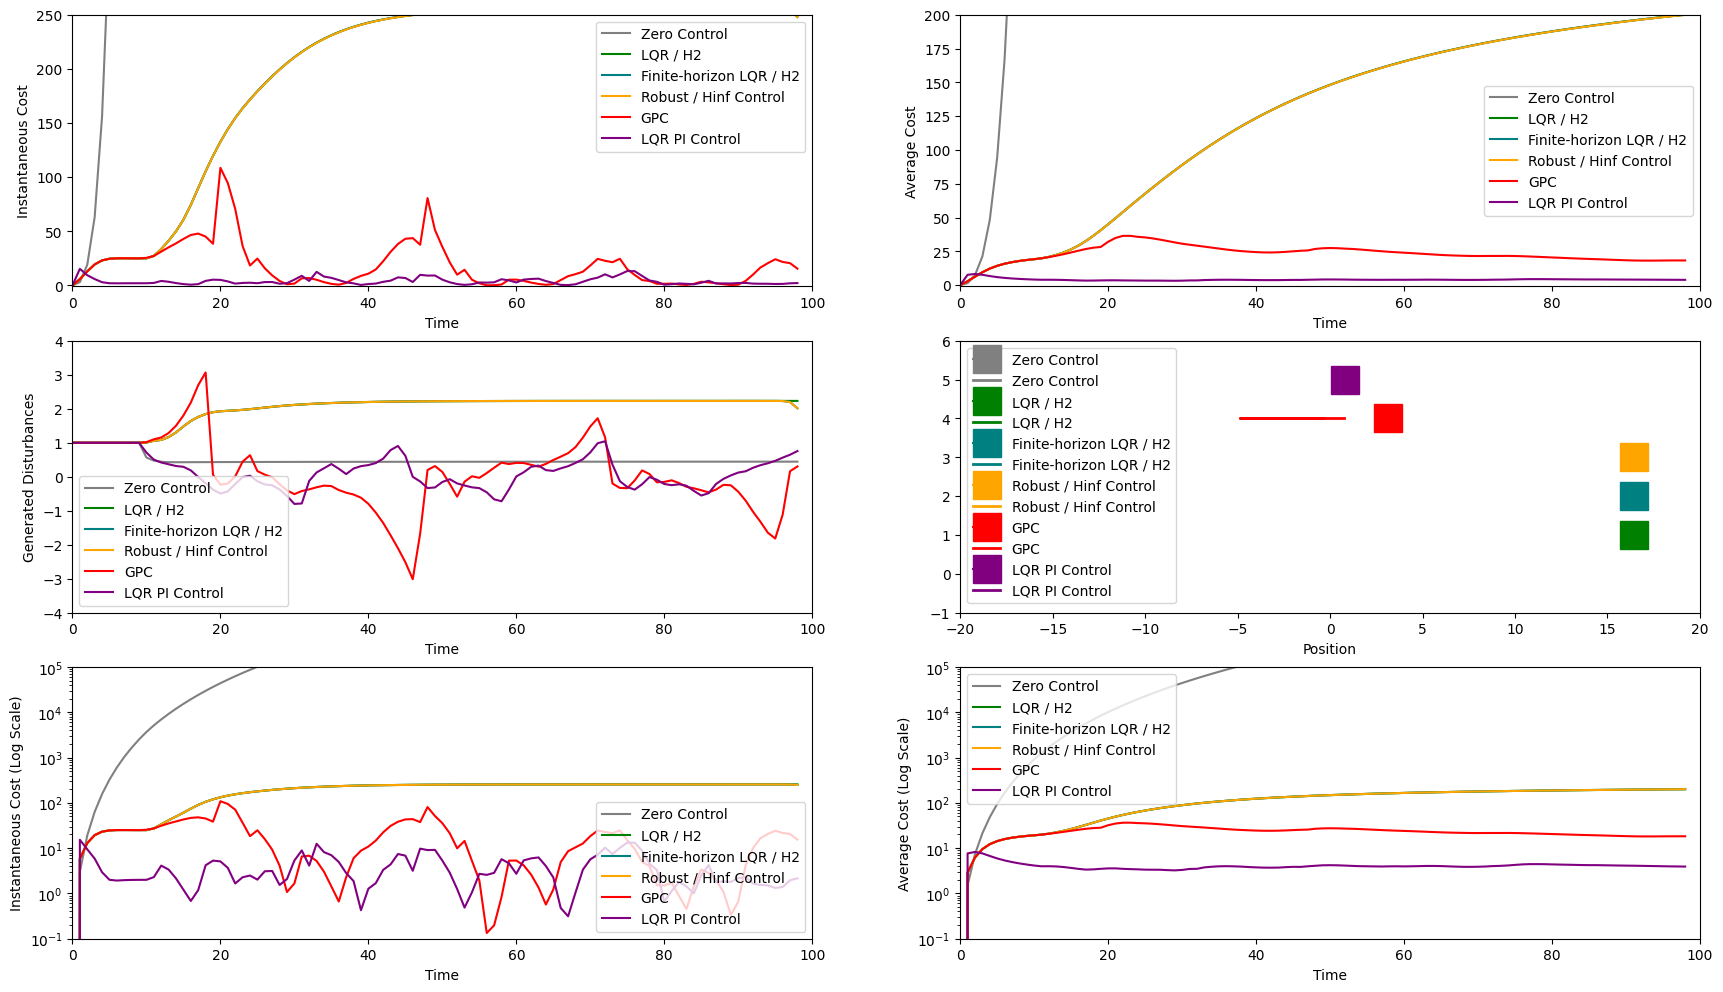

In [ ]:
#@title MOTR Pertrubation
#@markdown Environment Parameters
motr_offset_radius = 1 #@param {type:"slider", min:0, max:2, step:0.01}
motr_radius = 0.4 #@param {type:"slider", min:0, max:2, step:0.01}
motr_lookback = 5 #@param {type:"slider", min:1, max:20, step:1}
motr_memory = 5 #@param {type:"slider", min:1, max:20, step:1}
motr_gen = motr(r_off=motr_offset_radius, r_E=motr_radius, M=motr_memory, H=motr_lookback)

#@markdown Constant Pertrubation: Control parameters
hinf_log_gamma = 2 #@param {type:"slider", min:-2, max:5, step:0.01}
hinf_gamma = 10**(hinf_log_gamma)
gpc_lookback = 5 #@param {type:"slider", min:1, max:20, step:1}
gpc_memory = 5 #@param {type:"slider", min:1, max:20, step:1}
gpc_log_lr = -3 #@param {type:"slider", min:-5, max:0, step:0.01}
gpc_lr = 10**(gpc_log_lr)
Q_integral_weight=2.05 #@param {type:"slider", min:0.75, max:4, step:0.1}

Cs = controllers(hinf_gamma, gpc_lookback, gpc_memory, gpc_lr, Q_integral_weight)


print("🧛 evaluating controllers")
traces = {Cstr: list(zip(*eval(C, motr_gen))) for Cstr, C in Cs.items()}
xss = valmap(lambda x: x[0], traces)
uss = valmap(lambda x: x[1], traces)
wss = valmap(lambda x: x[2], traces)
costss = valmap(lambda x: x[3], traces)

liveplot(costss, xss, wss, 250, 200, 4, 20, 10**5, 10**5)